# Training and Testing Lasso RF with Pumping

In [1]:
#Load models 
import sys
sys.path.insert(1,'/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ')

from random_forest_sklearn import random_forest
from sklearn import linear_model
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import torch
from torch.utils.data import Dataset
import xarray
from parflow.tools.io import read_pfb, write_pfb
import numpy as np
import pandas as pd

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from joblib import dump, load

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import ListedColormap

import rioxarray

import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin

import tifffile

from sklearn.preprocessing import MinMaxScaler

/home/jk48/.conda/envs/ML_env/lib/python3.11/site-packages/parflow/tools/io.py:805: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/jk48/.conda/envs/ML_env/lib/python3.11/site-packages/parflow/tools/io.py:837: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/home/jk48/.conda/envs/ML_env/lib/python3.11/site-packages/parflow/tools/io.py:860: NumbaD

In [3]:
'''
Dataloader for Climatological WTD mean difference estimation over CONUS2
'''

class WTD_Mean_Estimation_NJ_Dataset(Dataset):
    '''
    Return dataset used to contruct ML models for estimating climatological mean water table depth (WTD) difference
    over NJ.
    
    Climatological mean WTD difference = Climatological mean WTD - Long-term mean WTD

    Input data are:
                    1. climatological mean precipitation difference (cmean_P_diff);
                    2. climatological mean temperature difference (cmean_T_diff);
                    3. precipitation minus evapotranspiration (PME);
                    4. elevation (elev);
                    5. topographic slope (slope);
                    6. natural log of hydraulic conductivity (lnK);
                    7. long-term mean WTD (ldmean_WTD)
                    8. month

    Output data are: climatological mean water table depth difference (cmean_WTD_diff)

    :param in_vars:
        Input variables.
    :param out_vars:
        Output variables.
    :param grid_cell_indexes:
        Indexes of grid cells where data are obtained. Shape: [nsamples,2]
    :param month:
        month in which the data are specified
    :param base_dirs:
        Locations of data used to construct ML models. 
    '''
    def __init__(
        self,
        in_vars=None,
        out_vars=None,
        grid_cell_indexes=None,
        month=None,
        base_dirs=['/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/transit_study_data/',
                  '/home/SHARED/data/ym5379/NJ_pumping_records/',
                  '/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/']
    ):
        
        super().__init__()
        self.in_vars = in_vars
        self.out_vars = out_vars

        n_features = len(in_vars)

        x_new = np.empty([n_features,grid_cell_indexes.shape[0]],dtype=np.float32)
        y_new = np.empty([1,grid_cell_indexes.shape[0]],dtype=np.float32)
        
        ##Load data## 
        train_df = pd.read_csv('/home/jk48/Senior_Thesis/training_dataset_with_LU_and_pumping.csv') 
            
        x_new[0,:] = train_df['P'].to_numpy()[grid_cell_indexes]-train_df['mP'].to_numpy()[grid_cell_indexes]
        x_new[1,:] = train_df['T'].to_numpy()[grid_cell_indexes]-train_df['mT'].to_numpy()[grid_cell_indexes]
        x_new[2,:] = train_df['PME'].to_numpy()[grid_cell_indexes]
        x_new[3,:] = train_df['elev'].to_numpy()[grid_cell_indexes]
        x_new[4,:] = train_df['slope'].to_numpy()[grid_cell_indexes]
        x_new[5,:] = train_df['lnK'].to_numpy()[grid_cell_indexes]
        x_new[6,:] = train_df['mwtd'].to_numpy()[grid_cell_indexes] #long term mean WTD
        x_new[7,:] = train_df['wtd'].to_numpy()[grid_cell_indexes]-train_df['mwtd'].to_numpy()[grid_cell_indexes]
        x_new[8,:] = train_df['TYPE15_NUMBERED'].to_numpy()[grid_cell_indexes]
        
        # Cross metric
        for i in grid_cell_indexes:
            if x_new[2, i] > 0.0055 and x_new[2, i] < 0.0008:
                x_new[2, i] = 0
            else:
                x_new[2, i] = 1
            if x_new[8,i] == 1 or x_new[8,i] == 4:
                x_new[8,i] = 0
            else:
                x_new[8,i] = 1
            if x_new[7,i] > -0.01 and x_new[7,i] < 0.01:
                x_new[7,i] = 0
            else:
                x_new[7,i] = 1
                
        x_new[9,:] = (x_new[2,:] + x_new[7,:] + x_new[5,:]) * x_new[1,:]
        x_new[1,:] = train_df['T'].to_numpy()[grid_cell_indexes]-train_df['mT'].to_numpy()[grid_cell_indexes]
        x_new[2,:] = train_df['PME'].to_numpy()[grid_cell_indexes]
        x_new[7,:] = train_df['wtd'].to_numpy()[grid_cell_indexes]-train_df['mwtd'].to_numpy()[grid_cell_indexes]
        x_new[8,:] = train_df['TYPE15_NUMBERED'].to_numpy()[grid_cell_indexes]
    
        
        y_new[0,:] = train_df['WithdrawalMG'].to_numpy()[grid_cell_indexes]
     
        self.in_data = torch.from_numpy(np.stack(x_new)).type(torch.float32).reshape(n_features,-1)
        self.out_data = torch.from_numpy(y_new).type(torch.float32).reshape(1,-1)
        
    def __getitem__(self, idx):
        return (self.in_data[:,idx], self.out_data[:,idx])

    def __len__(self):
        return self.in_data.shape[1]

    def is_numpy(self):
        return (self.in_data.numpy(),self.out_data.numpy())

In [4]:
#in_vars = ['P_mP','T_mT','PME','elev','slope','lnK','mwtd','wtd-mwtd','land_cover']
in_vars = ['P_mP','T_mT','PME','elev','slope','lnK','mwtd','wtd-mwtd','land_cover', 'cross_metric']
out_vars = ['WithdrawalMG']

train_df = pd.read_csv('/home/jk48/Senior_Thesis/training_dataset_with_LU_and_pumping.csv')

obs_num = train_df.shape[0]
print('Number of grid cells with observations:',obs_num)

np.random.seed(0)

dataset = WTD_Mean_Estimation_NJ_Dataset(in_vars,out_vars,
                                             grid_cell_indexes=np.arange(obs_num))

X_tensor, y_tensor = dataset[:]
X = np.swapaxes(X_tensor.numpy(),0,1) #input shape (n_samples, n_features)
y = np.swapaxes(y_tensor.numpy(),0,1)

#Randomly select data
train_index = np.random.choice(obs_num,int(obs_num*0.8),replace=False)

mask = np.isin(np.arange(obs_num),train_index)
test_index = np.arange(obs_num)[~mask]

#np.savetxt('train_index_3s_CONUS2.txt',train_index)
#np.savetxt('test_index_3s_CONUS2.txt',test_index)

print(train_index.shape[0])
print(test_index.shape[0])
print(np.isin(train_index,test_index).any())

np.random.shuffle(train_index) #Shuffle training data

X_train = X[train_index,:]
X_test = X[test_index,:]
y_train = y[train_index,:]
y_test = y[test_index,:]

Number of grid cells with observations: 47280
37824
9456
False


In [5]:
#Train a lasso regression
lasso_model = linear_model.Lasso(alpha=0.0005)
lasso_model.fit(X_train,y_train)

lasso_train_results = lasso_model.predict(X_train)
lasso_test_results = lasso_model.predict(X_test)

train_r2_score = r2_score(y_train,lasso_train_results)
test_r2_score = r2_score(y_test,lasso_test_results)

train_rmse_score = mse(y_train,lasso_train_results,squared=False)
test_rmse_score = mse(y_test,lasso_test_results,squared=False)

print('Train NSE:',train_r2_score)
print('Test NSE:',test_r2_score)

print('Train RMSE:',train_rmse_score)
print('Test RMSE:',test_rmse_score)

Train NSE: 0.007427855766326097
Test NSE: 0.009818600185036885
Train RMSE: 7.761824
Test RMSE: 5.2322593


In [6]:
#Optimal random forest hyperparameters
max_samples = 0.8
max_features = 5
n_estimators = 300
max_depth = 900
min_samples_leaf = 1

#Train RF
# RF_model = random_forest(in_vars,
#                           out_vars,
#                           max_samples=max_samples,
#                           max_features=max_features,
#                           n_estimators=n_estimators,
#                           max_depth=max_depth,
#                           min_samples_leaf=min_samples_leaf)

# RF_model.train((X_train,y_train - lasso_train_results.reshape(-1,1)))
# dump(RF_model.rf_model,'trained_lasso_RF_for_WTD_cmean_diff_estimator_v_20230717.model')

# Use this to compute SHAP values or permutation importance
RF_model = RandomForestRegressor(max_samples=max_samples, 
                                 max_features=max_features, 
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 min_samples_leaf=min_samples_leaf)

RF_model.fit(X_train,y_train - lasso_train_results.reshape(-1,1))
y_hat = RF_model.predict(X_train)
loss = mse(y_train - lasso_train_results.reshape(-1,1),y_hat)

dump(RF_model,'trained_lasso_RF_for_WTD_cmean_diff_estimator_v_20230717.model')

#Calculate the median of the results of the decision trees in the random forest
#estimators = RF_model.rf_model.estimators_
estimators = RF_model.estimators_
train_results = []
test_results = []

#Obtain results from each tree
for n in range(n_estimators):
    train_results.append(estimators[n].predict(X_train))
    test_results.append(estimators[n].predict(X_test))

/tmp/ipykernel_878410/1312277087.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(X_train,y_train - lasso_train_results.reshape(-1,1))


In [7]:
# Median
train_r2_score = r2_score(y_train,np.median(np.array(train_results),axis=0)+lasso_train_results)
test_r2_score = r2_score(y_test,np.median(np.array(test_results),axis=0)+lasso_test_results)

train_rmse_score = mse(y_train,np.median(np.array(train_results),axis=0)+lasso_train_results,squared=False)
test_rmse_score = mse(y_test,np.median(np.array(test_results),axis=0)+lasso_test_results,squared=False)

train_r_score = stats.pearsonr(y_train.reshape(-1),np.median(np.array(train_results),axis=0)+lasso_train_results)[0]
test_r_score = stats.pearsonr(y_test.reshape(-1),np.median(np.array(test_results),axis=0)+lasso_test_results)[0]

print('Train NSE:',train_r2_score)
print('Test NSE:',test_r2_score)

print('Train RMSE:',train_rmse_score)
print('Test RMSE:',test_rmse_score)

print('Train R:',train_r_score)
print('Test R:',test_r_score)

Train NSE: 0.9972735737345013
Test NSE: 0.3988073145823485
Train RMSE: 0.40679877297505596
Test RMSE: 4.076981386062324
Train R: 0.998636029267014
Test R: 0.6451224983264141


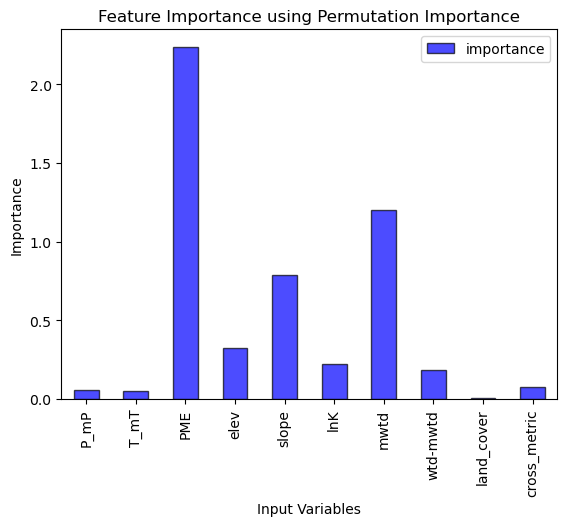

In [13]:
# Create a dataframe
import_df = pd.DataFrame()
import_df['importance'] = result.importances_mean
import_df['variables'] = in_vars

# Plot permutation importance
ax = import_df.plot.bar(x='variables', y='importance', color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Input Variables')
plt.ylabel('Importance')
plt.title('Feature Importance using Permutation Importance')

plt.show()

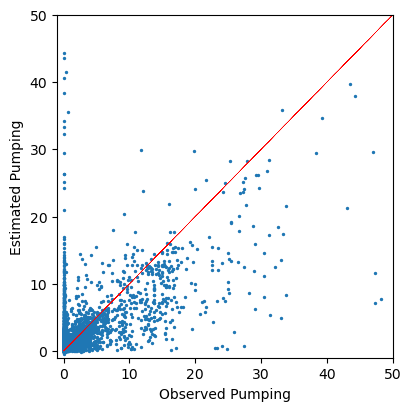

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)
ax1.scatter(y_test,np.mean(np.array(test_results),axis=0)+lasso_test_results,s=2)
ax1.plot(y_test,y_test,'r--',lw=0.1)
plt.xlim(-1,50)
plt.ylim(-1,50)
plt.xlabel('Observed Pumping')
plt.ylabel('Estimated Pumping')
plt.savefig('test.png',dpi=300)

In [12]:
# Number of false positives in testing with cross metric using 4 diff input variables
zeros = y_test==0
true_indices = np.where(zeros[:,0])[0]
zero_pumping = X_test[true_indices,:]

threshold_values = [2, 5, 10]

# Iterate through different threshold values
for i in threshold_values:
    non_zeros = (np.mean(np.array(test_results), axis=0) + lasso_test_results > i)
    true_indices = np.where(zeros[:, 0] & non_zeros)[0]
    false_pos = X_test[true_indices, :]
    print(f"Threshold: {i}, False Positives: {len(false_pos)}")

Threshold: 2, False Positives: 328
Threshold: 5, False Positives: 113
Threshold: 10, False Positives: 43


# Testing the Inverse Model

In [8]:
'''
Dataloader for WTD anomaly estimation over NJ
'''

class WTD_Anomaly_Estimation_NJ_Dataset(Dataset):
    '''
    Return input dataset used to contruct ML models for estimating water table depth (WTD) anomaly
    over NJ for a specific date.

    Input data are:
                    1. P anomaly;
                    2. T anomaly;
                    3. precipitation minus evapotranspiration (PME);
                    4. elevation (elev);
                    5. topographic slope (slope);
                    6. natural log of hydraulic conductivity (lnK);
                    7. estimated long-term mean WTD (mwtd);
                    8. Land cover

    Output data are: water table depth anomaly (wtd_a)

    :param in_vars:
        Input variables.
    :param out_vars:
        Output variables.
    :param date:
        Study date. Format: 'YYYY-MM-DD'.
    :param base_dirs:
        Locations of data used to construct ML models. 
    '''
    def __init__(
        self,
        in_vars=None,
        out_vars=None,
        study_date=None,
        base_dirs=['/home/SHARED/data/ym5379/WTD_RF_estimates/CONUS2_input/',
                   '/home/SHARED/data/ym5379/NJ_experiment/NJ_data/',
                   '/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/',
                   '/hydrodata/forcing/processed_data/CONUS2/CW3E/monthly/']
    ):
        super().__init__()
        self.in_vars = in_vars
        self.out_vars = out_vars
        
        #Load location files
        x_pixel_arr_all = np.load(base_dirs[2]+'x_indexes_90m_NJ.npy')
        y_pixel_arr_all = np.load(base_dirs[2]+'y_indexes_90m_NJ.npy')
        
        x_pixel_arr_all_GW_withdrawal = np.load(base_dirs[2]+'x_indexes_90m_Withdrawals_NJ.npy')
        y_pixel_arr_all_GW_withdrawal = np.load(base_dirs[2]+'y_indexes_90m_Withdrawals_NJ.npy')
        
        mask = np.isnan(x_pixel_arr_all) + np.isnan(y_pixel_arr_all) + np.isnan(x_pixel_arr_all_GW_withdrawal) + np.isnan(y_pixel_arr_all_GW_withdrawal)

        mask[mask>0] = 1

        x_pixel_arr_all[np.isnan(x_pixel_arr_all)] = 0
        y_pixel_arr_all[np.isnan(y_pixel_arr_all)] = 0
        
        x_pixel_arr_all_GW_withdrawal[np.isnan(x_pixel_arr_all_GW_withdrawal)] = 0
        y_pixel_arr_all_GW_withdrawal[np.isnan(y_pixel_arr_all_GW_withdrawal)] = 0

        n_features = len(in_vars)
        nx = x_pixel_arr_all.shape[1]
        ny = x_pixel_arr_all.shape[0]

        x_new = np.empty([n_features,nx*ny],dtype=np.float32)
        y_new = np.empty([1,nx*ny],dtype=np.float32)
    
        ##Load input data##  
        #PME
        x_new[2,:] = read_pfb(base_dirs[0]+'1km_CONUS2_PME_fixed_GPU.pfb')[9,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                  x_pixel_arr_all.reshape(-1).astype(int)]
        #lnK
        x_new[5,:] = read_pfb(base_dirs[0]+'lnK_CONUS2.pfb')[0,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                    x_pixel_arr_all.reshape(-1).astype(int)]
        
        #Elev
        elev_dataset = rioxarray.open_rasterio(base_dirs[1]+'NJ_3s_DEM.tif')
        elev_dataset = elev_dataset.astype('float32')

        elev_data = elev_dataset.data
        x_new[3,:] = elev_data[0,:,:].reshape(-1)
        
        #Slope
        slope_dataset = rioxarray.open_rasterio(base_dirs[1]+'NJ_3s_slope.tif')
        slope_data = slope_dataset.data
        slope_data[slope_data==-9999.0] = np.nan
        slope_data = np.tan(slope_data*np.pi/180)
        x_new[4,:] = slope_data[0,:,:].reshape(-1)
        
        #mwtd
        x_new[6,:] = rioxarray.open_rasterio(base_dirs[2]+'wtd_mean_estimate_RF_3s_CONUS_model_NJ_m_v_20230519.tif').data[0,:,:].reshape(-1)
        
        #GW pumping
        HUC14 = rioxarray.open_rasterio(base_dirs[1]+'NJ_90m_HUC14.tif').data[0,:,:][y_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int),
                                                                                                    x_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int)]
        
        
        #Landcover
        land_cover = rioxarray.open_rasterio('/home/jk48/Senior_Thesis/land_cover.tif').data[0,:,:][y_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int),
                                                                                                    x_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int)]
        
        
        lu = category_map(land_cover)
        
        x_new[8,:] = lu
        
        #wtd-mwtd
        wtd_anomaly = pd.read_csv('/home/jk48/Senior_Thesis/wtd_predictions.csv')
        x_new[7,:] = wtd_anomaly['wtd_est']
        
        wtd_anomaly[wtd_anomaly['wtd_est']==wtd_anomaly['wtd_est'][0]]=np.nan
        wtd_std = wtd_anomaly['wtd_est'].std()
        
        wtd_anomaly = pd.read_csv('/home/jk48/Senior_Thesis/wtd_predictions.csv')

        #P & T anomaly 
        year = pd.to_datetime(study_date).year
        month = pd.to_datetime(study_date).month

        #Water Year
        if month > 9:
            year_d = year + 1
            index = month - 10
        else:
            year_d = year 
            index = month + 12 - 10
        
        P_arr = read_pfb(base_dirs[3]+'CW3E.APCP.monthly.sum.WY'+str(year_d)+'.pfb')[index,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                                x_pixel_arr_all.reshape(-1).astype(int)]
        T_arr = read_pfb(base_dirs[3]+'CW3E.Temp.monthly.mean.WY'+str(year_d)+'.pfb')[index,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                                x_pixel_arr_all.reshape(-1).astype(int)]


        lmeanP_data = read_pfb(base_dirs[0]+'long_term_mean_monthly_precipitation_CONUS2.pfb')[0,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                                x_pixel_arr_all.reshape(-1).astype(int)]
        lmeanT_data = read_pfb(base_dirs[0]+'long_term_mean_monthly_temperature_CONUS2.pfb')[0,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                                x_pixel_arr_all.reshape(-1).astype(int)]
        
        x_new[0,:] = P_arr - lmeanP_data
        x_new[1,:] = T_arr - lmeanT_data
        
        # Cross metric (best performance)
        for i in range(6260800):
            if x_new[2, i] > 0.0055 and x_new[2, i] < 0.0008:
                x_new[2, i] = 0
            else:
                x_new[2, i] = 1
            if x_new[8,i] == 1 or x_new[8,i] == 4:
                x_new[8,i] = 0
            else:
                x_new[8,i] = 1
            if x_new[7,i] > -0.01 and x_new[7,i] < 0.01:
                x_new[7,i] = 0
            else:
                x_new[7,i] = 1
        
        x_new[9,:] = (x_new[2,:] + x_new[7,:] + x_new[5,:]) * x_new[1,:]
        
        x_new[8,:] = lu
        
        x_new[2,:] = read_pfb(base_dirs[0]+'1km_CONUS2_PME_fixed_GPU.pfb')[9,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                                  x_pixel_arr_all.reshape(-1).astype(int)]
        x_new[5,:] = read_pfb(base_dirs[0]+'lnK_CONUS2.pfb')[0,:,:][y_pixel_arr_all.reshape(-1).astype(int),
                                                                    x_pixel_arr_all.reshape(-1).astype(int)]
        x_new[7,:] = wtd_anomaly['wtd_est']
        
        #GW pumping
        HUC14 = rioxarray.open_rasterio(base_dirs[1]+'NJ_90m_HUC14.tif').data[0,:,:][y_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int),
                                                                                                    x_pixel_arr_all_GW_withdrawal.reshape(-1).astype(int)]
        
        #Load Pumping data
        GW_withdrawal_dataset = pd.read_csv('/home/SHARED/data/ym5379/NJ_pumping_records/DGS10-3-With-HUC/HUCWithdrawal.csv')
        GW_withdrawal_dataset['Date'] = pd.to_datetime(GW_withdrawal_dataset.YearNumber.astype(str)+'/'+GW_withdrawal_dataset.MonthNumber.astype(str)+'/01')
        GW_withdrawal_dataset = GW_withdrawal_dataset.drop(columns=['SiteName','YearNumber','MonthNumber','TransferEffectiveDate','DataSource'])

        GW_withdrawal_dataset = GW_withdrawal_dataset[GW_withdrawal_dataset['Date']==study_date]
        
        GW_withdrawal_90m_data = np.empty(ny*nx) * np.nan
        count = 0

        for HUC14_index in np.unique(HUC14[~np.isnan(HUC14)]):

            if GW_withdrawal_dataset[GW_withdrawal_dataset['HUC14']==int(HUC14_index)].shape[0] != 0:
                GW_withdrawal_90m_data[HUC14==HUC14_index] = GW_withdrawal_dataset[GW_withdrawal_dataset['HUC14']==int(HUC14_index)]['WithdrawalMG'].mean()
            else:
                count += 1
                GW_withdrawal_90m_data[HUC14==HUC14_index] = 0
                
        
        y_new[0,:] = GW_withdrawal_90m_data
        
        
        #Set mask as nan
        mask = mask.reshape(-1) + np.isnan(x_new[5,:]) + np.isnan(x_new[3,:]) + np.isnan(x_new[4,:]) + np.isnan(x_new[6,:]) + np.isnan(x_new[7,:])
        mask[mask>1] = 1
        
        x_new[:,mask] = -9999
        y_new[:,mask] = -9999
        
        self.in_data = torch.from_numpy(np.stack(x_new)).type(torch.float32).reshape(n_features,-1)
        self.out_data = torch.from_numpy(np.stack(y_new)).type(torch.float32).reshape(1,-1)
        self.x_pixel_arr_all = torch.from_numpy(x_pixel_arr_all).type(torch.float32)
        self.mask = torch.from_numpy(mask).type(torch.float32)
        self.lu = torch.from_numpy(lu).type(torch.float32)

        
    def __getitem__(self, idx):
        return self.in_data[:,idx], self.x_pixel_arr_all, self.mask, self.lu, self.out_data[:,idx]

    def __len__(self):
        return self.in_data.shape[1]

    def is_numpy(self):
        return (self.in_data.numpy(), self.out_data.numpy())

In [9]:
def category_map(arr):

    category_mapping = {
        (0, 2000): 1,
        (2000, 3000): 4,
        (4000, 5000): 3,
        (5000, 8000): 2
    }

    # Replace categories with mapped values
    mapped_arr = np.zeros_like(arr)
    for category_range, mapped_value in category_mapping.items():
        lower_bound, upper_bound = category_range
        mapped_arr[(arr >= lower_bound) & (arr < upper_bound)] = mapped_value
    
    return mapped_arr

In [10]:
in_vars = ['P-mP','T-mT','PME','elev','slope','lnK','mwtd','wtd-mwtd','land_cover','cross_metric'] # Need WTD as an input
out_vars = ['pumping']

In [11]:
input_dataset = WTD_Anomaly_Estimation_NJ_Dataset(in_vars, out_vars,
                                                  study_date='2015-01-01')
    
X_tensor, X_pixel_tensor, mask_tensor, lu_tensor, y_tensor = input_dataset[:]
X = np.swapaxes(X_tensor.numpy(),0,1)#input shape (n_samples, n_features)
y = np.swapaxes(y_tensor.numpy(),0,1)
X_pixel_array = X_pixel_tensor.numpy()
mask_real = mask_tensor.numpy()
lu = lu_tensor.numpy()

In [12]:
lasso_results = lasso_model.predict(X)
results = []

#Obtain results from each tree
for n in range(n_estimators):
    results.append(estimators[n].predict(X))
    
predictions = np.mean(np.array(results),axis=0)+lasso_results
predictions

array([51344.70878258, 51344.70878258, 51344.70878258, ...,
       51344.70878258, 51344.70878258, 51344.70878258])

In [80]:
# Group together the true pumping and predicted pumping values together
df1 = pd.DataFrame(y)
df2 = pd.DataFrame(predictions)
y_pred = pd.concat([df1, df2], axis=1)
y_pred = pd.DataFrame(data=y_pred.values, columns=['Y', 'Pred'])
means = y_pred.groupby('Y')['Pred'].transform('mean')
y_pred['Pred'] = means
y_pred['RMSE'] = (y_pred['Y'] - y_pred['Pred'])
y_pred[y_pred['Y']==-9999.0]=np.nan
y_pred[y_pred['Y']>100.0]=np.nan
y_pred[y_pred['Pred']>80]=np.nan

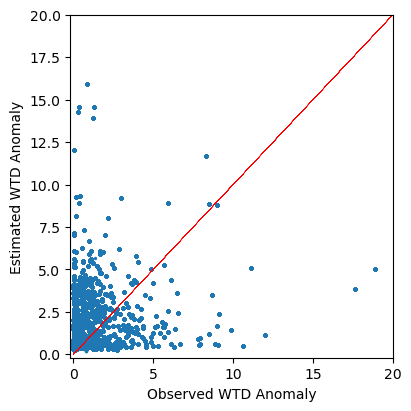

In [22]:
fig, ax1 = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)
ax1.scatter(y_pred['Y'],y_pred['Pred'],s=2)
ax1.plot(y_test,y_test,'r--',lw=0.1)
plt.xlim(-0.2,20)
plt.ylim(-0.2,20)
plt.xlabel('Observed WTD Anomaly')
plt.ylabel('Estimated WTD Anomaly')
plt.savefig('test.png',dpi=300)

In [65]:
x_pixel_arr_all = np.load('/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/x_indexes_90m_NJ.npy')
y_pixel_arr_all = np.load('/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/y_indexes_90m_NJ.npy')

x_pixel_arr_all_GW_withdrawal = np.load('/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/x_indexes_90m_Withdrawals_NJ.npy')
y_pixel_arr_all_GW_withdrawal = np.load('/home/SHARED/data/ym5379/NJ_experiment/WTD_estimates_NJ/Input_preprocessing/y_indexes_90m_Withdrawals_NJ.npy')
        
mask = np.isnan(x_pixel_arr_all) + np.isnan(y_pixel_arr_all) + np.isnan(x_pixel_arr_all_GW_withdrawal) + np.isnan(y_pixel_arr_all_GW_withdrawal)
mask[mask>0] = 1

x_pixel_arr_all[np.isnan(x_pixel_arr_all)] = 0
y_pixel_arr_all[np.isnan(y_pixel_arr_all)] = 0
        
x_pixel_arr_all_GW_withdrawal[np.isnan(x_pixel_arr_all_GW_withdrawal)] = 0
y_pixel_arr_all_GW_withdrawal[np.isnan(y_pixel_arr_all_GW_withdrawal)] = 0

nx = x_pixel_arr_all_GW_withdrawal.shape[1]
ny = y_pixel_arr_all_GW_withdrawal.shape[0]

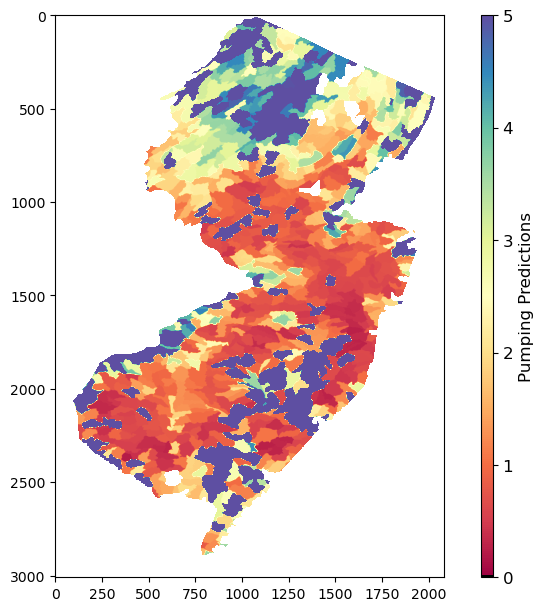

In [14]:
fig, ax1 = plt.subplots(1,1,figsize=(8,6),constrained_layout=True)

custom_value = 0
original_cmap = plt.cm.Spectral
new_color = [0, 0, 255, 1]  # Black color as [R, G, B, alpha]
custom_cmap_colors = [original_cmap(i) for i in range(original_cmap.N)]
custom_cmap_colors[0] = new_color
custom_cmap = ListedColormap(custom_cmap_colors)
vmin = -1

im1 = plt.imshow(y_pred['Pred'].values.reshape(ny,nx), vmin=0, vmax =5, cmap=custom_cmap)
cbar1 = plt.colorbar(im1,ax=ax1,shrink=1,aspect=50,orientation='vertical')
cbar1.set_label('Pumping Predictions',fontsize=12)
cbar1.ax.tick_params(labelsize=12)